# Artificial Neural Network Implementation

#### Append window path to import modules

In [1]:
import sys
sys.path.append('/mnt/c/Users/sumit/PycharmProjects/research')

### Define Global Parameter and variables

In [2]:
input_node = 784
hidden_layer_node = [ 1024, 1024 ]
output_node = 10
batch_size = 128
intial_learning_rate = 0.001
optimizer = "SGD"
epoch = 20

### MNIST Dataset

In [3]:
import mnist_loader
train_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
train_data = np.array([*train_data])
validation_data = np.array(list(validation_data))
test_data = np.array(list(test_data))

In [6]:
print("shape of training set - ", train_data.shape)
print("shape of validation set - ", validation_data.shape)
print("shape of test set - ", test_data.shape)

shape of training set -  (50000, 2)
shape of validation set -  (10000, 2)
shape of test set -  (10000, 2)


In [7]:
train_x = train_data[:, 0]
train_y = train_data[:, 1]
test_x = test_data[:, 0]
test_y = test_data[:, 1]

In [8]:
print("shape of train data", np.array(train_x).shape, train_y.shape)
print("shape of test data", test_x.shape, test_y.shape)

shape of train data (50000,) (50000,)
shape of test data (10000,) (10000,)


#### Batch Function

In [9]:
def create_batch(X, Y, batch_size = 32):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], Y[i:i+batch_size]

### Define a Neural Network Model

In [10]:
class Model():
    
    def __init__(self, input_node, hidden_layer_node, 
                 output_node, alpha, optimizer, 
                 weights = None, bias = None ):
        """
        Initialize the neural network 
        :param input_node: number of input nodes
        :param hidden_layer_node: number of hidden nodes
        must be array of size 2
        :param output_node: number of output class
        :param alpha: learning rate
        :param optimizer: optimizer function
        :param weights: weights of network
        :param bias: bias of network
        """
        self.optimizer = optimizer
        self.alpha = alpha
        self.output_node = output_node
        self.hidden_layer_node = hidden_layer_node
        self.input_node = input_node
        self.weights = weights if weights else np.array( [
            np.random.randn(hidden_layer_node[0], input_node),
            np.random.randn(hidden_layer_node[1], hidden_layer_node[0]),
            np.random.randn(output_node, hidden_layer_node[1])
        ])
        self.bias = bias if bias else np.array( [
            np.random.randn(hidden_layer_node[0]),
            np.random.randn(hidden_layer_node[1]),
            np.random.randn(output_node)
        ])
    
    def sigmoid(self, Z):
        
        return 1.0 / ( 1.0 + np.exp(-Z) )
    
    def create_batch(self, X, Y, batch_size = 32):
        for i in range(0, len(X), batch_size):
            yield X[i:i+batch_size], Y[i:i+batch_size]
        
    def forward(self, X):
        """
        forward implementation of neural network
        :param X: input vectors of m training examples
        suppose single input image have 28*28 pixel means total 784 pixels 
        then size of single input vector will (1, 784) but their is m training examples
        so size of input will be (m, 784)
        shape - (m, n) m - size of examples and n - size of single input
        :return: output of neural network
        """
        #   Output from first layer
        Z1 = np.dot(X, self.weights[0].T) + self.bias[0]
        A1 = self.sigmoid(Z1)
        Z2 = np.dot(A1, self.weights[1].T) + self.bias[1]
        A2 = self.sigmoid(Z2)
        Z3 = np.dot(A2, self.weights[2].T) + self.bias[2]
        output = self.sigmoid(Z3)
        
        return output
    
    def backward(self, X, Y):
        """
        implementation of backward algorithm to compute gradient of weights and bias
        :param X: (m,n) - input
        :param Y: (m, 10)output vector
        :return: (delta_weight, delta_bias) - gradient of weights and bias
        """
        # initialized nabla weight and bias
        delta_weight = [ np.zeros(i.shape) for i in self.weights]
        delta_bias = [np.zeros(i.shape) for i in self.bias]
        
        # store activation to compute delta
        activation = [X]
        Z1 = np.dot(X, self.weights[0].T) + self.bias[0]
        A1 = self.sigmoid(Z1)
        activation.append(A1)
        Z2 = np.dot(A1, self.weights[1].T) + self.bias[1]
        A2 = self.sigmoid(Z2)
        activation.append(A2)
        Z3 = np.dot(A2, self.weights[2].T) + self.bias[2]
        output = self.sigmoid(Z3)
        activation.append(output)
        
        # compute nabla for last layer
        delta = (activation[-1] - Y)
        delta_weight[-1] = np.dot(delta.T, activation[-2])
        delta_bias[-1] = np.sum(delta, axis=0)
        
        delta = np.dot(delta, self.weights[-1]) * activation[-2] * (1 - activation[-2])
        delta_weight[-2] = np.dot(delta.T, activation[-3])
        delta_bias[-2] = np.sum(delta, axis=0)
        
        delta = np.dot(delta, self.weights[-2]) * activation[-3] * (1 - activation[-3])
        delta_weight[-2] = np.dot(delta.T, activation[-3])
        delta_bias[-2] = np.sum(delta, axis=0)
        
        return np.array(delta_weight), np.array(delta_bias)
        
    def softmax(self, scores):
        return np.exp(scores)/np.sum(np.exp(scores), axis=0)
    
    def training(self, train_data, epoch, batch_size, alpha):
        for i in tqdm(range(epoch)):
            np.random.shuffle(train_data)
            train_x = train_data[:, 0]
            train_y = train_data[:, 1]
            nabla_weight = [np.zeros(i.shape) for i in self.weights]
            nabla_bias = [np.zeros(i.shape) for i in self.bias]
            for X,Y in create_batch(train_x, train_y, batch_size):
                X = np.array([ i.reshape(input_node) for i in X ])
                Y = np.array([ i.reshape(output_node) for i in Y ])
                delta_weight, delta_bias = model.backward(X, Y)
                nabla_weight = nabla_weight + delta_weight
                nabla_bias = nabla_bias + delta_bias
                self.weights = self.weights - alpha * (1.0 / batch_size) * nabla_weight
                self.bias = self.bias - alpha * (1.0 / batch_size) * nabla_bias
                
    
        

#### train the model

In [11]:
model = Model(input_node, hidden_layer_node, output_node, 
              intial_learning_rate, optimizer)

model.training(train_data, epoch=epoch, batch_size=batch_size, 
               alpha=intial_learning_rate)

100%|██████████| 20/20 [05:57<00:00, 17.88s/it]


#### test the model

In [12]:
temp_X = np.array([ i.reshape(input_node) for i in train_x ])
temp_Y = np.array([ i.reshape(output_node) for i in train_y ])

In [13]:
pred = np.argmax(model.forward(temp_X), axis=1)
actual = np.argmax(temp_Y, axis=1)

In [14]:
np.sum(pred == actual)/50000

0.68176

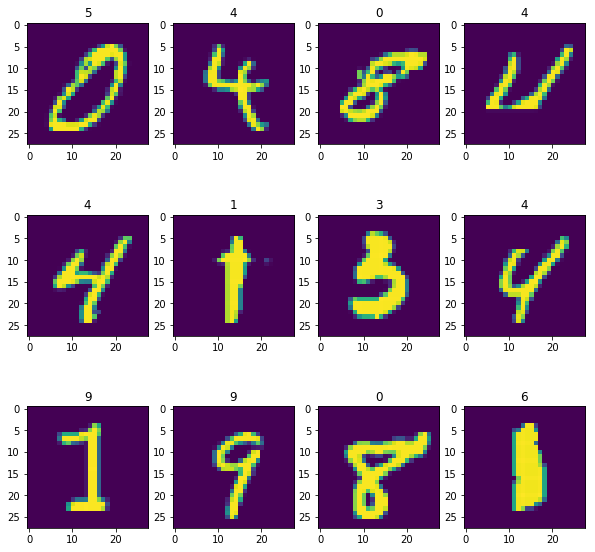

In [15]:
for X,Y in create_batch(train_x, train_y, 12):
    X = np.array([ i.reshape(input_node) for i in X ])
    Y = np.array([ i.reshape(output_node) for i in Y ])
    prediction = model.forward(X)
    plt.figure(figsize=(10, 10))
    for i in range(X.shape[0]):
        plt.subplot(X.shape[0]//4, 4, i+1)
        plt.imshow(X[i].reshape((28, 28)))
        plt.title(np.argmax(prediction[i]))
    break